# DEPHY Forcing Derivation

- Code to generate: initial and time-varying profile and surface forcing
- Developed by Tim Juliano (NCAR-RAL), Ann Fridlind (NASA-GISS), and Florian Tornow (NASA-GISS/Columbia Univ.) with substantial contributions by Peng Wu (PNNL), Gunilla Svensson (Stockholm Univ.), and Andy Ackerman (NASA-GISS)
- v2.2 created on 6/26/23
- Based on ERA5 backward trajectory, beginning at Andenes, Norway (03/13/20 at 18 UTC)
- We have the option of starting as far as 28 hours before arriving at Andenes (03/12/20 at 14 UTC)

## Import libraries

In [49]:
import numpy as np
import numpy.ma as ma
import sys
from netCDF4 import Dataset, date2num
import datetime as dt
import os
import matplotlib.pyplot as plt
from scipy import interpolate
import geopy.distance
from scipy.ndimage import gaussian_filter1d

## User mods
1. How many hours before ice edge do you want to start?
- Note: Value == 0 means you are starting approx. at ice edge, Value == 10 means you are starting 10 h upstream (north) of the ice edge
- Note: Value must be an integer
- Note: t0_h represents simulation start time, t0_h_init_th_qv represents initial theta/qv profile to use; set equivalent if everything should be initialized using information at same time

In [50]:
t0_h = 2
t0_h_init_th_qv = 5
if t0_h < 0 or t0_h > 10:
    sys.exit('Error: Please set 0 <= t0_h >= 10')

2. Clobber old forcing file?

In [51]:
clobber_old_file = True

3. Forcing file save name
- Note: For this and all file paths, include directory in the name

In [52]:
save_name = 'COMBLE_INTERCOMPARISON_FORCING_V2.2.nc'

4. Name of current script for global attribute
- Note: Can use ipynbname library to automatically generate script name, but this is not a standard library so skipping for now

In [53]:
script_name = 'create_comble_forcing_v2.2.ipynb'

5. LES domain locations

In [54]:
fname_les_domain = 'LES_domain_location_28h_18Z_Mar13_2020.txt'

6. ERA5 backward trajectory met file name

In [55]:
fname_era5_met = 'theta_temp_rh_sh_uvw_sst_along_trajectory_era5ml_28h_end_2020-03-13-18_v2.nc'

7. ERA5 backward trajectory ozone file name

In [56]:
fname_era5_o3 = 'ERA5_forcing_along_trajectory_end_2020-03-13-18.nc'

8. 1D model profiles file name

In [57]:
profiles_1d_model = 'u_v_theta_z.txt'

9. Sea ice concentration file name

In [58]:
fname_sic = 'Svalbard_asi-AMSR2-n10m-20200313_m.nc'

10. Do geostrophic wind calc and add to forcing file? If so, supply ERA5 geopotential height file name and minimum grid spacing (km) for discretization

In [59]:
do_geo = True
if do_geo:
    fname_era5_geo = '/glade/scratch/tjuliano/doe_comble/wrf_asr_cao/WRF-ASR-CAO/scripts/era5/era5_mar13_case_larger.nc'
    min_dx = 20.
    min_dy = 20.

11. Add theta and qv nudging, as well as subsidence, to forcing file?

In [60]:
do_u_v_nudge = True
do_th_qv_nudge = True
do_subsidence = True

## Set things for future calculations

- Note: no need for user to modify these, computed automatically

- Timings

In [61]:
nhrs = 18 + t0_h + 1 # total number of simulation hours, including t0
if t0_h == 0:
    start_time = '2020-03-13 00:00:00'
    start_day = 13
    start_hour = 0
else:
    start_time = '2020-03-12 ' + str(24-t0_h) + ':00:00'
    start_day = 12
    start_hour = 24-t0_h
print ('Start time is: ' + start_time)

Start time is: 2020-03-12 22:00:00


- Constants for geostrophic wind calc

In [62]:
if do_geo:
    omega = 7.2921e-5 # angular velocity
    g = 9.81 # grav constant

- Delete forcing file if already exists

In [63]:
if clobber_old_file:
    if os.path.exists(save_name):
        os.remove(save_name)
        print('The file ' + save_name + ' has been deleted successfully')

- Get LES domain locations

In [64]:
les_loc = np.loadtxt(fname_les_domain,skiprows=1)
les_hh = les_loc[:,0]
les_hh_idx = np.where(les_hh>=-1.*t0_h)[0]
les_lat = les_loc[les_hh_idx,1]
les_lat2 = les_lat[::12]
les_lon = les_loc[les_hh_idx,2]
les_lon2 = les_lon[::12]

les_lat_mid = round(np.mean(les_lat),1)
les_lon_mid = round(np.mean(les_lon),1)
print ('LES domain mid point: ' + 'lat=' + str(les_lat_mid) + 'N, lon=' + str(les_lon_mid) + 'E')

LES domain mid point: lat=74.5N, lon=9.9E


## Create vertical grid
- 160 vertical grid levels, defined at the cell faces

In [65]:
nz = 160

dz_grid = np.empty(nz-1)
dz_grid[0] = 20.0
dz_grid[1] = 25.0
dz_grid[2] = 30.0
dz_grid[3] = 35.0
dz_grid[4:140] = 40.0
dz_grid[140] = 60.0
dz_grid[141:157] = 80.0
dz_grid[157] = 60.0
dz_grid[158] = 50.0

z_grid = np.empty(nz)
z_grid[0] = 0.0
for i in np.arange(1,len(z_grid)):
    z_grid[i] = z_grid[i-1] + dz_grid[i-1]

## Read in data from ERA5 backtrajectory (netCDF)

In [66]:
# Open met dataset
dataset = Dataset(fname_era5_met, "r")

# Read variables (1D arrays are time, 2D arrays are time x pressure level)
hours = dataset.variables['Time'][:]
lat = dataset.variables['Latitude'][:]
lon = dataset.variables['Longitude'][:]
pres = dataset.variables['Pressure'][:,:]
sfc_pres = dataset.variables['SfcPres'][:]
sst = dataset.variables['SST'][:]
hgt = dataset.variables['GEOS_HT'][:,:]
uwnd = dataset.variables['U'][:,:]
vwnd = dataset.variables['V'][:,:]
wwnd = dataset.variables['W'][:,:]
temp = dataset.variables['Temp'][:,:]
theta = dataset.variables['Theta'][:,:]
qv = dataset.variables['SH'][:,:]

# Open ozone dataset
dataset_o3 = Dataset(fname_era5_o3, "r")

# Read variables
o3 = dataset_o3.variables['O3'][:,:]
pres_o3 = dataset_o3.variables['Pressure'][:]

- Convert units

In [67]:
pres_pa = pres*100.          # hPa to Pa
pres_o3_pa = pres_o3*100.    # hPa to Pa

- Reverse time dimension of 2D arrays, as well as sfc pressure and sst, so that beginning of backward trajectory is in first position

In [68]:
hgt = np.flip(hgt,axis=0)
uwnd = np.flip(uwnd,axis=0)
vwnd = np.flip(vwnd,axis=0)
wwnd = np.flip(wwnd,axis=0)
temp = np.flip(temp,axis=0)
theta = np.flip(theta,axis=0)
pres_pa = np.flip(pres_pa,axis=0)
qv = np.flip(qv,axis=0)
o3 = np.flip(o3,axis=0)
sfc_pres = sfc_pres[::-1]
sst = sst[::-1]

- Unmask sst field and get index according to t0_h (furthest north we can go is 28h after backtrajectory initialization from Andenes, or 3/12/20 at 14 UTC)

In [69]:
sst_real = ma.getdata(sst)
loopidx = np.where(sst_real>0.0)[0]
t0 = loopidx[10-t0_h]
t0_init_th_qv = loopidx[10-t0_h_init_th_qv]

- Calculate sfc potential temperature

In [70]:
theta1000mb = theta[:,0]
sfc_theta = theta1000mb*pow((100000./sfc_pres),0.286)

- Get information at t0

In [71]:
z1 = 0

pres_t0 = pres_pa[t0,z1:]
pres_o3_t0 = pres_o3_pa[z1:]
hgt_t0 = hgt[t0_init_th_qv,z1:]
uwnd_t0 = uwnd[t0,z1:]
vwnd_t0 = vwnd[t0,z1:]
wwnd_t0 = wwnd[t0,z1:]
temp_t0 = temp[t0_init_th_qv,z1:]
theta_t0 = theta[t0_init_th_qv,z1:]
qv_t0 = qv[t0_init_th_qv,z1:]

# temporal avg for o3
o3_t0 = np.mean(o3[0:18+t0_h+1,z1:],axis=0)

ps_t0 = sfc_pres[t0]
thetas_t0 = sfc_theta[t0]

- Extrapolate O3 since ERA5 only goes to 1 hPa and plot versus original profile

<Figure size 432x288 with 0 Axes>

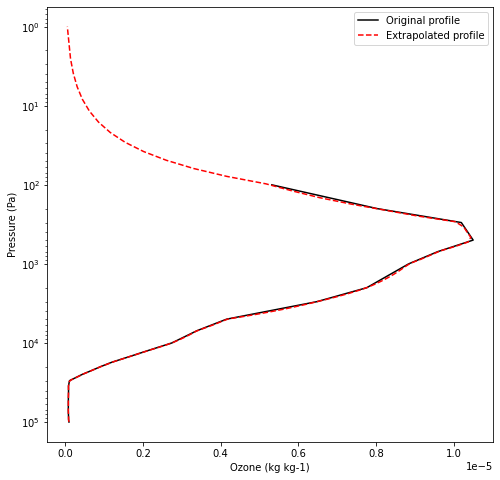

In [72]:
# Add top pressure and o3 value - here we assume o3 goes to zero at 1e-4 Pa
pres_o3_t0_add_top = np.insert(pres_o3_t0,len(pres_o3_t0),0.0001)
o3_t0_add_top = np.insert(o3_t0,len(o3_t0),0.0)

# Add bottom pressure and o3 value - here we assume o3 is constant near the sfc
pres_o3_t0_add_top_bottom = np.insert(pres_o3_t0_add_top,0,pres_t0[0])
o3_t0_add_top_bottom = np.insert(o3_t0_add_top,0,o3_t0[0])

# Do the extrapolation
f = interpolate.interp1d(pres_o3_t0_add_top_bottom, o3_t0_add_top_bottom, kind='linear',fill_value='extrapolate')
o3_t0i = f(pres_t0.data)

plt.figure()
plt.figure(figsize=(8,8))

var_plt1 = o3_t0
var_plt2 = o3_t0i
plt.plot(var_plt1,pres_o3_t0,c='k',label='Original profile')
plt.plot(var_plt2,pres_t0,c='r',ls='--',label='Extrapolated profile')
plt.legend()
plt.xlabel('Ozone (kg kg-1)')
plt.ylabel('Pressure (Pa)')
plt.yscale('log')
plt.gca().invert_yaxis()

plt.show()

## Get Geostrophic wind forcing

In [73]:
if do_geo:
    # Read ERA5 file
    dataset = Dataset(fname_era5_geo, "r")

    zl = dataset.variables['z'][24-t0_h:43,0:-1,:,:] # time, lev, lat, lon
    lonarrl = dataset.variables['longitude'][:]
    latarrl = dataset.variables['latitude'][:]

    latloc = np.empty(len(les_lat2),dtype=np.int16)
    lonloc = np.empty(len(les_lat2),dtype=np.int16)
    ugl = np.empty([len(les_lat2),np.shape(zl)[1]])
    vgl = np.empty([len(les_lat2),np.shape(zl)[1]])
    zhtl = np.empty([len(les_lat2),np.shape(zl)[1]])

    for i in np.arange(len(les_lat2)):
        hold = np.abs(les_lat2[i]-latarrl)
        latloc[i] = np.argmin(hold)
        hold = np.abs(les_lon2[i]-lonarrl)   
        lonloc[i] = np.argmin(hold)

        # Coriolis parameter
        e = 2*omega*np.cos(np.radians(les_lat2[i]))
        f = 2*omega*np.sin(np.radians(les_lat2[i]))

        # Calc dx, dy
        offset1 = 1
        offset2 = 1
        coords_1 = (latarrl[latloc[i]], lonarrl[lonloc[i]-offset2])
        coords_2 = (latarrl[latloc[i]], lonarrl[lonloc[i]+offset2])
        dx = geopy.distance.geodesic(coords_1, coords_2).km
        coords_3 = (latarrl[latloc[i]-offset1], lonarrl[lonloc[i]])
        coords_4 = (latarrl[latloc[i]+offset1], lonarrl[lonloc[i]])
        dy = geopy.distance.geodesic(coords_3, coords_4).km
        while dx < min_dx: # we want at least min_dx km for our zonal discretization, which changes with time (latitude)
            offset2+=1
            coords_1 = (latarrl[latloc[i]], lonarrl[lonloc[i]-offset2])
            coords_2 = (latarrl[latloc[i]], lonarrl[lonloc[i]+offset2])
            dx = geopy.distance.geodesic(coords_1, coords_2).km
        while dy < min_dy: # we want at least min_dy km for our meridional discretization, which stays mostly constant with time (latitude)
            offset1+=1
            coords_3 = (latarrl[latloc[i]-offset1], lonarrl[lonloc[i]])
            coords_4 = (latarrl[latloc[i]+offset1], lonarrl[lonloc[i]])
            dy = geopy.distance.geodesic(coords_3, coords_4).km

        dx = dx*1000. # km to m
        dy = dy*1000.

        # Calc Vg
        ugl[i,:] = (-1./f) * (zl[i,:,latloc[i]-offset1,lonloc[i]]-zl[i,:,latloc[i]+offset1,lonloc[i]])/dy
        vgl[i,:] = (1/f)  * (zl[i,:,latloc[i],lonloc[i]+offset2]-zl[i,:,latloc[i],lonloc[i]-offset2])/dx
        zhtl[i,:] = zl[i,:,latloc[i],lonloc[i]]/g

    ugeo = np.flip(ugl,1)
    vgeo = np.flip(vgl,1)
    zgeo = np.flip(zhtl,1)

    ugeo = gaussian_filter1d(ugeo, 1)
    vgeo = gaussian_filter1d(vgeo, 1)

    print ('Geostrophic wind computed')

Geostrophic wind computed


## Interpolate profiles

- Interpolate/extrapolate Ug/Vg to native ERA5 levels

In [74]:
if do_geo:
    ugeo_new = np.empty([np.shape(ugeo)[0],np.shape(hgt)[1]])
    vgeo_new = np.empty([np.shape(ugeo)[0],np.shape(hgt)[1]])
    zgeo_new = np.empty([np.shape(ugeo)[0],np.shape(hgt)[1]])
    for i in np.arange(len(les_lat2)):
        zgeo_new[i,:] = hgt[t0+i,z1:]

        f = interpolate.interp1d(zgeo[i,:], ugeo[i,:], bounds_error=False, fill_value='extrapolate')
        ugeo_new[i,:] = f(zgeo_new[i,:].data)

        f = interpolate.interp1d(zgeo[i,:], vgeo[i,:], bounds_error=False, fill_value='extrapolate')
        vgeo_new[i,:] = f(zgeo_new[i,:].data)

Interpolate t0 profiles, nudging profiles, and geostrophic wind profiles to common vertical grid for simplicity

- Find time with highest first level and get vertical grid

In [75]:
if do_geo:
    zz1_geo = np.empty([nhrs,len(pres_t0)])
    count = 0
    for i in np.arange(nhrs):
        zz1_geo[count,:] = zgeo_new[i,0]

        count+=1

    zz1_nudge = np.empty([nhrs,len(pres_t0)])
    count = 0
    for i in np.arange(nhrs):
        zz1_nudge[count,:] = hgt[t0+i,z1:]

        count+=1

    zz1_geo_max_idx = np.argmax(zz1_geo[:,0])
    zz1_nudge_max_idx = np.argmax(zz1_nudge[:,0])
    zz1_geo_max = zz1_geo[zz1_geo_max_idx,0]
    zz1_nudge_max = zz1_nudge[zz1_nudge_max_idx,0]

    if zz1_geo_max > zz1_nudge_max:
        zgeoi = zz1_geo[zz1_geo_max_idx,0:-1]
    else:
        zgeoi = zz1_nudge[zz1_nudge_max_idx,0:-1]
        
else:
    zz1_nudge = np.empty([nhrs,len(pres_t0)])
    count = 0
    for i in np.arange(nhrs):
        zz1_nudge[count,:] = hgt[t0+i,z1:]

        count+=1

    zz1_nudge_max_idx = np.argmax(zz1_nudge[:,0])
    zz1_nudge_max = zz1_nudge[zz1_nudge_max_idx,0]

    zgeoi = zz1_nudge[zz1_nudge_max_idx,0:-1]

print ('First level for all profiles = ' + str(round(zgeoi[0],3)) + ' m' )
print (zgeoi)

First level for all profiles = 18.168 m
[1.81678200e+01 3.78291588e+01 5.93531876e+01 8.29409561e+01
 1.08634644e+02 1.36762817e+02 1.67474060e+02 2.01006256e+02
 2.37572968e+02 2.77470947e+02 3.20925720e+02 3.68243713e+02
 4.19705322e+02 4.75707489e+02 5.36504822e+02 6.02413635e+02
 6.73863464e+02 7.51188721e+02 8.34781677e+02 9.25015015e+02
 1.02229761e+03 1.12704102e+03 1.23956067e+03 1.36028394e+03
 1.48945679e+03 1.62738745e+03 1.77428064e+03 1.93038416e+03
 2.09574048e+03 2.27039331e+03 2.45438965e+03 2.64754395e+03
 2.84974072e+03 3.06066577e+03 3.27992432e+03 3.50704077e+03
 3.74134668e+03 3.98210889e+03 4.22867920e+03 4.48078857e+03
 4.73797949e+03 4.99874365e+03 5.26092578e+03 5.52306201e+03
 5.78483252e+03 6.04644922e+03 6.30803760e+03 6.56951123e+03
 6.83091602e+03 7.09283643e+03 7.35596924e+03 7.62092139e+03
 7.88798877e+03 8.15741553e+03 8.42925000e+03 8.70381738e+03
 8.98155176e+03 9.26270898e+03 9.54723730e+03 9.83502930e+03
 1.01259678e+04 1.04200625e+04 1.07173477e+04

- Do the linear interpolation of time-varying geostrophic profiles to new vertical grid

In [76]:
if do_geo:
    ugeoi = np.empty([nhrs,len(pres_t0)-1])
    vgeoi = np.empty([nhrs,len(pres_t0)-1])
    count = 0
    for i in np.arange(nhrs):
        f = interpolate.interp1d(zgeo_new[i,:], ugeo_new[i,:])
        ugeoi[count,:] = f(zgeoi)
        f = interpolate.interp1d(zgeo_new[i,:], vgeo_new[i,:])
        vgeoi[count,:] = f(zgeoi)

        count+=1

- Compare original and interpolated profiles of time-varying geostrophic wind as example to show efficacy of method

<Figure size 432x288 with 0 Axes>

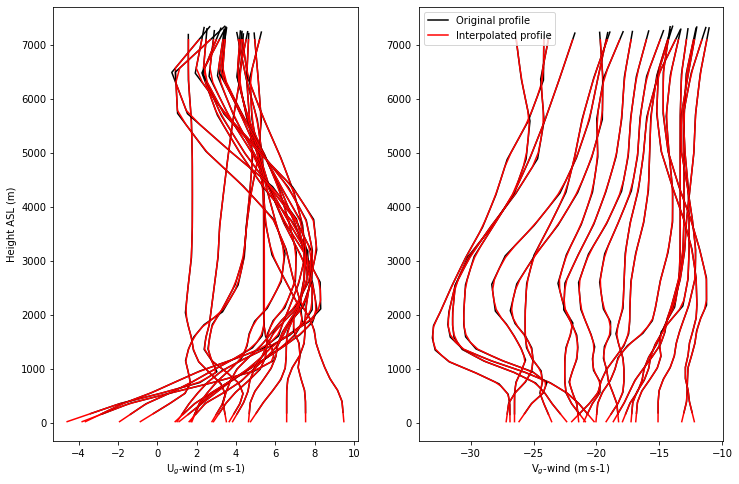

In [77]:
zplt1 = 0
zplt2 = nhrs-3
zplt2b = 50

if do_geo:
    plt.figure()
    plt.figure(figsize=(12,8))

    var_plt1 = ugeo
    var_plt2 = ugeoi
    plt.subplot(121)
    for i in np.arange(nhrs):
        plt.plot(var_plt1[i,zplt1:zplt2],zgeo[i,zplt1:zplt2],c='k')
        plt.plot(var_plt2[i,zplt1:zplt2b],zgeoi[zplt1:zplt2b],c='r')
    plt.xlabel('U$_{g}$-wind (m s-1)')
    plt.ylabel('Height ASL (m)')

    var_plt1 = vgeo
    var_plt2 = vgeoi
    plt.subplot(122)
    for i in np.arange(nhrs):
        if i == 0:
            plt.plot(var_plt1[i,zplt1:zplt2],zgeo[i,zplt1:zplt2],c='k',label='Original profile')
            plt.plot(var_plt2[i,zplt1:zplt2b],zgeoi[zplt1:zplt2b],c='r',label='Interpolated profile')
        else:
            plt.plot(var_plt1[i,zplt1:zplt2],zgeo[i,zplt1:zplt2],c='k')
            plt.plot(var_plt2[i,zplt1:zplt2b],zgeoi[zplt1:zplt2b],c='r')
    plt.xlabel('V$_{g}$-wind (m s-1)')
    plt.legend()
    plt.show()

- Do the linear interpolation for initial forcing profiles

In [78]:
f = interpolate.interp1d(hgt_t0, pres_t0)
pres_t0i = f(zgeoi)
f = interpolate.interp1d(hgt_t0, uwnd_t0)
uwnd_t0i = f(zgeoi)
f = interpolate.interp1d(hgt_t0, vwnd_t0)
vwnd_t0i = f(zgeoi)
f = interpolate.interp1d(hgt_t0, wwnd_t0)
wwnd_t0i = f(zgeoi)
f = interpolate.interp1d(hgt_t0, temp_t0)
temp_t0i = f(zgeoi)
f = interpolate.interp1d(hgt_t0, theta_t0)
theta_t0i = f(zgeoi)
f = interpolate.interp1d(hgt_t0, qv_t0)
qv_t0i = f(zgeoi)
f = interpolate.interp1d(hgt_t0, o3_t0i)
o3_t0i = f(zgeoi)

- Do the linear interpolation for nudging forcing profiles

In [79]:
if do_u_v_nudge:
    unudgei = np.empty([nhrs,len(pres_t0)-1])
    vnudgei = np.empty([nhrs,len(pres_t0)-1])
if do_th_qv_nudge:
    tnudgei = np.empty([nhrs,len(pres_t0)-1])
    qvnudgei = np.empty([nhrs,len(pres_t0)-1])
if do_subsidence:
    wnudgei = np.empty([nhrs,len(pres_t0)-1])
count = 0
if do_u_v_nudge or do_th_qv_nudge or do_subsidence:
    for i in np.arange(nhrs):
        if do_u_v_nudge:
            f = interpolate.interp1d(hgt[t0+i,z1:], uwnd[t0+i,z1:])
            unudgei[count,:] = f(zgeoi)
            f = interpolate.interp1d(hgt[t0+i,z1:], vwnd[t0+i,z1:])
            vnudgei[count,:] = f(zgeoi)

        if do_th_qv_nudge:
            f = interpolate.interp1d(hgt[t0+i,z1:], theta[t0+i,z1:])
            tnudgei[count,:] = f(zgeoi)

            f = interpolate.interp1d(hgt[t0+i,z1:], qv[t0+i,z1:])
            qvnudgei[count,:] = f(zgeoi)
        if do_subsidence:
            f = interpolate.interp1d(hgt[t0+i,z1:], wwnd[t0+i,z1:])
            wnudgei[count,:] = f(zgeoi)

        count+=1

- Compare original and interpolated profiles of time-varying nudging wind as example to show efficacy of method

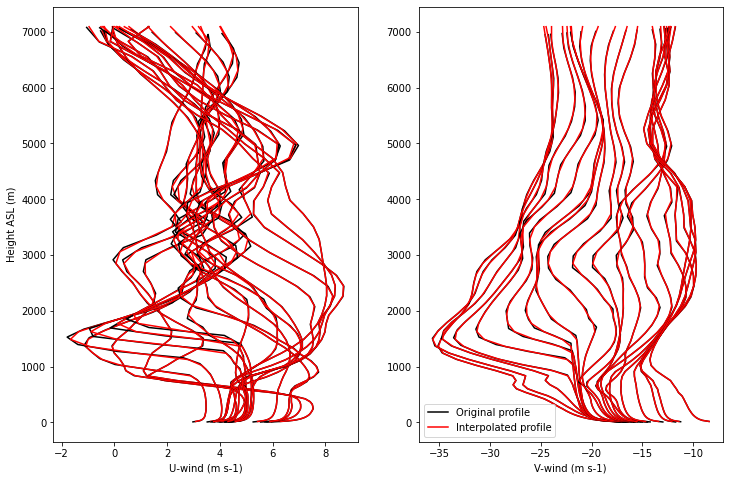

In [80]:
zplt1 = 0
zplt2 = 50
zplt2b = 50

if do_geo and do_u_v_nudge:
    plt.figure(figsize=(12,8))

    var_plt1 = uwnd
    var_plt2 = unudgei
    plt.subplot(121)
    for i in np.arange(nhrs):
        plt.plot(var_plt1[t0+i,zplt1:zplt2],hgt[t0+i,zplt1:zplt2],c='k')
        plt.plot(var_plt2[i,zplt1:zplt2b],zgeoi[zplt1:zplt2b],c='r')
    plt.xlabel('U-wind (m s-1)')
    plt.ylabel('Height ASL (m)')

    var_plt1 = vwnd
    var_plt2 = vnudgei
    plt.subplot(122)
    for i in np.arange(nhrs):
        if i == 0:
            plt.plot(var_plt1[t0+i,zplt1:zplt2],hgt[t0+i,zplt1:zplt2],c='k',label='Original profile')
            plt.plot(var_plt2[i,zplt1:zplt2b],zgeoi[zplt1:zplt2b],c='r',label='Interpolated profile')
        else:
            plt.plot(var_plt1[t0+i,zplt1:zplt2],hgt[t0+i,zplt1:zplt2],c='k')
            plt.plot(var_plt2[i,zplt1:zplt2b],zgeoi[zplt1:zplt2b],c='r')
    plt.xlabel('V-wind (m s-1)')
    plt.legend()
    plt.show()

## Shift profiles downward according to Ann's method

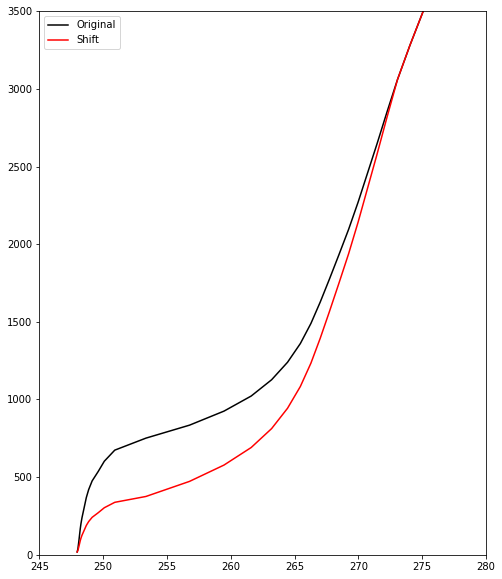

In [81]:
# Adjusted height
zgeoi_shift = np.zeros(len(zgeoi))
zgeoi_shift[0] = zgeoi[0]

zmid_idx = 17 # ~middle of inversion
zgeoi_shift[zmid_idx] = zgeoi[zmid_idx]/2.
zstop_idx = 33
zstop = 3000. # m, where we want to stop loop

zgeoi_shift[zstop_idx:] = zgeoi[zstop_idx:]

count = 1
while zgeoi[count] < zstop:
    if count < zmid_idx:
        zgeoi_shift[count] = zgeoi[0] + ((zgeoi[count] - zgeoi[0]) / (zgeoi[zmid_idx] - zgeoi[0])) * (zgeoi_shift[zmid_idx] - zgeoi[0])
    elif count > zmid_idx:
        zgeoi_shift[count] = zgeoi_shift[zmid_idx] + (zgeoi[count] - zgeoi[zmid_idx]) / (zgeoi[zstop_idx] - zgeoi[zmid_idx]) * (zgeoi_shift[zstop_idx] - zgeoi_shift[zmid_idx])
    count+=1
    
plt.figure(figsize=(8,10))
plt.plot(theta_t0i,zgeoi,c='k',label='Original')
plt.plot(theta_t0i,zgeoi_shift,c='r',label='Shift')
plt.ylim(0,3500)
plt.xlim(245,280)
plt.legend()

- Smooth shifted initial water vapor mixing ratio profile

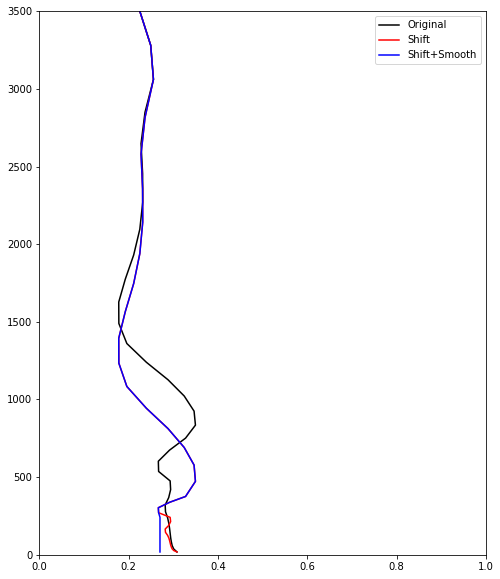

In [82]:
qv_t0i_mod = qv_t0i.copy()
qv_t0i_mod[0:14] = 0.27e-3

plt.figure(figsize=(8,10))
plt.plot(qv_t0i*1e3,zgeoi,c='k',label='Original')
plt.plot(qv_t0i*1e3,zgeoi_shift,c='r',label='Shift')
plt.plot(qv_t0i_mod*1e3,zgeoi_shift,c='b',label='Shift+Smooth')
plt.ylim(0,3500)
plt.xlim(0,1)
plt.legend()

## Using 1D model from Gunilla Svensson, approximate deviation from geostrophy and add offset to initial geostrophic winds for our initial wind profile

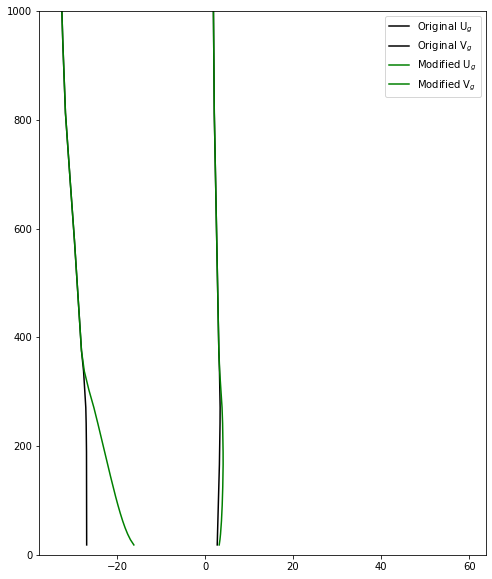

In [83]:
if do_geo:
    gunilla_data = np.genfromtxt(profiles_1d_model)
    gunilla_u = gunilla_data[0,:]
    gunilla_v = gunilla_data[1,:]
    gunilla_th = gunilla_data[2,:]
    gunilla_z = gunilla_data[3,:]

    # express the winds as offsets from geostrophic
    gunilla_du = gunilla_u - gunilla_u[-1]
    gunilla_dv = gunilla_v - gunilla_v[-1]

    # add offsets to the initial profile
    du = np.interp(zgeoi_shift,gunilla_z,gunilla_du)
    dv = np.interp(zgeoi_shift,gunilla_z,gunilla_dv)
    ugeoi_t0i_mod = ugeoi[0,:] + du
    vgeoi_t0i_mod = vgeoi[0,:] + dv

    plt.figure(figsize=(8,10))
    plt.plot(ugeoi[0,:],zgeoi_shift,c='k',label='Original U$_{g}$')
    plt.plot(vgeoi[0,:],zgeoi_shift,c='k',label='Original V$_{g}$')
    plt.plot(ugeoi_t0i_mod,zgeoi_shift,c='g',label='Modified U$_{g}$')
    plt.plot(vgeoi_t0i_mod,zgeoi_shift,c='g',label='Modified V$_{g}$')
    plt.ylim(0,1000)
    plt.legend()

## Do surface forcing

- Calculate sea ice concentration along trajectory

In [84]:
sic_file = Dataset(fname_sic)
sic = sic_file.variables['z'][:,:]
sic_lat = sic_file.variables['lat'][:]
sic_lon = sic_file.variables['lon'][:]

sic_traj = np.empty(len(les_hh_idx))
for i in np.arange(len(les_hh_idx)):
    abslat = np.abs(sic_lat-les_lat[i])
    abslon = np.abs(sic_lon-les_lon[i])
    jlat = np.argmin(abslat)
    ilon = np.argmin(abslon)
    sic_traj[i] = sic[jlat,ilon]

- Get time series information for sfc forcing

In [85]:
# Print statements?
verbose = False

# Pack ice skin temperature
tsk_ice = 247.0

# Interpolate SST
tmp_hh = np.arange(-1*t0_h,19,1) # these are the hours we have SST data from the ERA5 backward trajectory file
f = interpolate.interp1d(tmp_hh, sst[t0:])
sst_interp = f(les_hh[les_hh_idx])

# Modification for over ice/MIZ
sst_ts = np.empty(len(sic_traj))
for i in np.arange(len(sic_traj)):
    if sic_traj[i] > 90.0: # over ice
        sst_ts[i] = tsk_ice
    elif sic_traj[i] > 0.0: # MIZ
        sst_ts[i] = (sic_traj[i]/100.)*tsk_ice + (1.-(sic_traj[i]/100.))*sst_interp[i] # MIZ
    else: # open ocean
        sst_ts[i] = sst_interp[i]
    if verbose:
        print ('Computed TSK for hour ' + str(round(5*i/60.,3)) + ': '
               + str(round(sst_ts[i],3)) + ' with SIC = ' + str(sic_traj[i]/100.) +
               ' and SST = ' + str(round(sst_interp[i],3)))

# Pull hourly SST
sst_ts = sst_ts[::12]

## Create new netcdf file

In [86]:
try: ncfile.close()  # just to be safe, make sure dataset is not already open.
except: pass
ncfile = Dataset(save_name,mode='w',format='NETCDF3_CLASSIC')

- Create dimensions

In [87]:
levs = len(zgeoi_shift)
z_grid_levs = len(z_grid)
t0_dim = ncfile.createDimension('t0', 1)     # initial time axis
lat_dim = ncfile.createDimension('lat', 1)     # latitude axis
lon_dim = ncfile.createDimension('lon', 1)     # longitude axis
lev_dim = ncfile.createDimension('lev', levs)      # level axis
zw_grid_dim = ncfile.createDimension('zw_grid', z_grid_levs)      # zw_grid axis
time_dim = ncfile.createDimension('time', None)    # unlimited axis (can be appended to)

- Create global attributes

In [88]:
ncfile.title='Forcing and initial conditions for 13 March 2020 COMBLE intercomparison case'
ncfile.reference='https://arm-development.github.io/comble-mip/'
ncfile.authors='Timothy W. Juliano (NCAR/RAL, tjuliano@ucar.edu); Florian Tornow (NASA/GISS, ft2544@columbia.edu); Ann M. Fridlind (NASA/GISS, ann.fridlind@nasa.gov)'
ncfile.version='Created on ' + dt.date.today().strftime('%Y-%m-%d')
ncfile.format_version='DEPHY SCM format version 2.0'
ncfile.script=script_name
ncfile.comment='Simulations beginning prior to the ice edge set z0=0.001 m over ice then compute z0 using Charnock.'
ncfile.startDate=start_time
ncfile.endDate='2020-03-13 18:00:00'
if do_geo:
    ncfile.forc_geo=1
else:
    ncfile.forc_geo=0
ncfile.radiation='on'
ncfile.forc_wap=1
ncfile.forc_wa=0
ncfile.surface_type='landice-ocean'
ncfile.surface_forcing_temp='ts'
ncfile.surface_forcing_moisture='none'
ncfile.surface_forcing_wind='z0-none'
ncfile.lat=str(les_lat_mid) + ' deg N'
ncfile.dx='150 m'
ncfile.dy='150 m'
ncfile.dz='see zw_grid variable'
ncfile.nx='648'
ncfile.ny='648'
ncfile.nz='160'

Create variables

- Dimensions

In [89]:
t0_time = ncfile.createVariable('t0', np.float32, ('t0',))
t0_time.units = 'seconds since ' + start_time
t0_time.long_name = 'Initial time'

latitude = ncfile.createVariable('lat', np.float32, ('lat',))
latitude.units = 'degrees_north'
latitude.long_name = 'latitude'

longitude = ncfile.createVariable('lon', np.float32, ('lon',))
longitude.units = 'degrees_east'
longitude.long_name = 'longitude'

time = ncfile.createVariable('time', np.float64, ('time',))
time.units = 'seconds since ' + start_time
time.long_name = 'time'

lev = ncfile.createVariable('lev', np.float64, ('lev',))
lev.units = 'm'
lev.long_name = 'altitude'

- Initial profiles

In [90]:
pressure = ncfile.createVariable('pressure', np.float64, ('t0','lev','lat','lon',))
pressure.units = 'Pa'
pressure.long_name = 'pressure'

u = ncfile.createVariable('u', np.float64, ('t0','lev','lat','lon',))
u.units = 'm s-1'
u.long_name = 'zonal wind'

v = ncfile.createVariable('v', np.float64, ('t0','lev','lat','lon',))
v.units = 'm s-1'
v.long_name = 'meridional wind'

temperature = ncfile.createVariable('temp', np.float64, ('t0','lev','lat','lon',))
temperature.units = 'K'
temperature.long_name = 'temperature'

ptemperature = ncfile.createVariable('theta', np.float64, ('t0','lev','lat','lon',))
ptemperature.units = 'K'
ptemperature.long_name = 'potential temperature'

qvapor = ncfile.createVariable('qv', np.float64, ('t0','lev','lat','lon',))
qvapor.units = 'kg kg-1'
qvapor.long_name = 'specific humidity'

ozone = ncfile.createVariable('o3', np.float64, ('t0','lev','lat','lon',))
ozone.units = 'kg kg-1'
ozone.long_name = 'ozone mass mixing ratio'

- Initial sfc conditions

In [91]:
ps = ncfile.createVariable('ps', np.float64, ('t0','lat','lon',))
ps.units = 'Pa'
ps.long_name = 'surface pressure'

thetas = ncfile.createVariable('thetas', np.float64, ('t0','lat','lon',))
thetas.units = 'K'
thetas.long_name = 'surface potential temperature'

- Time-varying forcing - geostrophic

In [92]:
if do_geo == True:
    ug = ncfile.createVariable('ug', np.float64, ('time','lev',))
    ug.units = 'm s-1'
    ug.long_name = 'geostrophic zonal wind'

    vg = ncfile.createVariable('vg', np.float64, ('time','lev',))
    vg.units = 'm s-1'
    vg.long_name = 'geostrophic meridional wind'

- Time-varying forcing - nudging

In [93]:
if do_u_v_nudge:
    u_nudging = ncfile.createVariable('u_nudging', np.float64, ('time','lev',))
    u_nudging.units = 'm s-1'
    u_nudging.long_name = 'zonal wind profile for nudging'

    v_nudging = ncfile.createVariable('v_nudging', np.float64, ('time','lev',))
    v_nudging.units = 'm s-1'
    v_nudging.long_name = 'meridional wind profile for nudging'

if do_th_qv_nudge:
    theta_nudging = ncfile.createVariable('theta_nudging', np.float64, ('time','lev',))
    theta_nudging.units = 'K'
    theta_nudging.long_name = 'potential temperature profile for nudging'

    qv_nudging = ncfile.createVariable('qv_nudging', np.float64, ('time','lev',))
    qv_nudging.units = 'kg kg-1'
    qv_nudging.long_name = 'specific humidity profile for nudging'
    
if do_subsidence:
    w_nudging = ncfile.createVariable('w_nudging', np.float64, ('time','lev',))
    w_nudging.units = 'Pa s-1'
    w_nudging.long_name = 'vertical velocity for nudging'

- Time-varying forcing - surface

In [94]:
ts = ncfile.createVariable('ts', np.float64, ('time',))
ts.units = 'K'
ts.long_name = 'surface temperature'

- Time-varying locations

In [95]:
latitude_arr = ncfile.createVariable('lat_ref', np.float32, ('time',))
latitude_arr.units = 'degrees_north'
latitude_arr.long_name = 'reference latitude'

longitude_arr = ncfile.createVariable('lon_ref', np.float32, ('time',))
longitude_arr.units = 'degrees_east'
longitude_arr.long_name = 'reference longitude'

- Misc

In [96]:
zw_grid = ncfile.createVariable('zw_grid', np.float64, ('zw_grid',))
zw_grid.units = 'm'
zw_grid.long_name = 'grid altitude at cell faces'

- Write data

In [97]:
t0_time[:] = 0.0
latitude[:] = les_lat_mid
longitude[:] = les_lon_mid
latitude_arr[:] = les_lat2
longitude_arr[:] = les_lon2
lev[:] = zgeoi_shift
zw_grid[:] = z_grid
pressure[:] = pres_t0i
u[:] = ugeoi_t0i_mod
v[:] = vgeoi_t0i_mod
temperature[:] = temp_t0i
ptemperature[:] = theta_t0i
qvapor[:] = qv_t0i_mod
ozone[:] = o3_t0i

ps[:] = ps_t0
thetas[:] = thetas_t0

if do_geo:
    ug[:] = ugeoi
    vg[:] = vgeoi

if do_u_v_nudge:
    u_nudging[:] = unudgei
    v_nudging[:] = vnudgei

if do_th_qv_nudge:
    theta_nudging[:] = tnudgei
    qv_nudging[:] = qvnudgei
    
if do_subsidence:
    w_nudging[:] = wnudgei
    
ts[:] = sst_ts

- Add times

In [98]:
dates = []
verbose = False
for i in np.arange(nhrs):
    if nhrs == 19:
        dates.append(dt.datetime(2020,3,13,i))
        if verbose:
            print (dt.datetime(2020,3,13,i))
    else:
        if start_hour+i > 23:
            dates.append(dt.datetime(2020,3,13,start_hour+i-24))
            if verbose:
                print (dt.datetime(2020,3,13,start_hour+i-24))
        else:
            dates.append(dt.datetime(2020,3,12,start_hour+i))
            if verbose:
                print (dt.datetime(2020,3,12,start_hour+i))
times = date2num(dates, time.units)
time[:] = times

- Close the file

In [99]:
# first print the Dataset object to see what we've got
print(ncfile)
# close the Dataset.
ncfile.close(); print('Dataset is closed!')

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    title: Forcing and initial conditions for 13 March 2020 COMBLE intercomparison case
    reference: https://arm-development.github.io/comble-mip/
    authors: Timothy W. Juliano (NCAR/RAL, tjuliano@ucar.edu); Florian Tornow (NASA/GISS, ft2544@columbia.edu); Ann M. Fridlind (NASA/GISS, ann.fridlind@nasa.gov)
    version: Created on 2023-06-26
    format_version: DEPHY SCM format version 2.0
    script: create_comble_forcing_v2.2.ipynb
    comment: Simulations beginning prior to the ice edge set z0=0.001 m over ice then compute z0 using Charnock.
    startDate: 2020-03-12 22:00:00
    endDate: 2020-03-13 18:00:00
    forc_geo: 1
    radiation: on
    forc_wap: 1
    forc_wa: 0
    surface_type: landice-ocean
    surface_forcing_temp: ts
    surface_forcing_moisture: none
    surface_forcing_wind: z0-none
    lat: 74.5 deg N
    dx: 150 m
    dy: 150 m
    dz: see zw_grid variable
    nx: 6